### Proximal policy optimization

PPO [1] is trying to combine the two objectives into one: first that $\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}$ is maximized and secondly that the policy does not go far from the original policy in the action distribution space by not encouraging it (clipping)

Having collected experience $D_k$ from policy $\pi_k$, compute rewards-to-go $\hat{R}$ and advantage estimates $A=Q(s,a)-V(s,a)=r_t+\gamma v_{t+1}-v_t$ using value estimates.

Next, update $\theta$ using Adam steps until $D_{KL}(\theta|\theta_k)>\delta$ on objective

$$
L_1(\theta)=\frac{1}{|D|}\sum\limits_{\tau\in D_k}\sum\limits_{t=0}^{T_\tau}\min\left(\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)}A^{\pi_k}(s_t,a_t),g(\varepsilon,A^{\pi_k}(s_t,a_t))\right)
$$

with $g(\varepsilon, A)=\begin{cases}
(1+\varepsilon)A,&A\geq 0\\
(1-\varepsilon)A,&A< 0\\
\end{cases}$

and on 
$$
L_2(\varphi)=\frac{1}{|D|}\sum\limits_{\tau\in D_k}\sum\limits_{t=0}^{T_\tau}(V_\varphi(s_t)-\hat{R}_t)^2
$$


[1] https://spinningup.openai.com/en/latest/algorithms/ppo.html

In [1]:
from xvfbwrapper import Xvfb

#vdisplay = Xvfb()
#vdisplay.start()

# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["LIBGL_ALWAYS_SOFTWARE"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

import pandas as pd

In [2]:
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# to display environment data
# see https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885
from IPython import display

In [3]:
import sys
sys.path += ['/localhome/volodin/local/usr/bin']
sys.path

['',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python36.zip',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/lib-dynload',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/extensions',
 '/localhome/volodin/.ipython',
 '/localhome/volodin/local/usr/bin']

In [4]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

In [5]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [6]:
env = gym.make('CartPole-v0')

In [44]:
# number of dimensions in state
S_DIM = 4

# number of available actions
ACTIONS = 2

# discount factor
gamma_discount = 0.95

# PPO parameter (policy clipping)
epsilon = 0.1

# PPO delta parameter (when to stop iterations, max KL divergence)
delta = 0.01

In [45]:
def g(eps, A):
    """ function g(eps, A), see latex above """
    def step_fcn(x):
        return (tf.math.sign(x) + 1) / 2.
    return tf.multiply(step_fcn(A), A * (1 + epsilon)) + tf.multiply(step_fcn(-A), A * (1 - epsilon))

In [46]:
# states
states = tf.placeholder(tf.float64, shape = (None, S_DIM,))

# taken actions
actions = tf.placeholder(tf.int64, shape = (None,))

# rewards obtained
rewards = tf.placeholder(tf.float64, shape = (None,))

# discounted rewards obtained
discounted_rewards_to_go = tf.placeholder(tf.float64, shape = (None,))

def fc_layer(x, n, activation = tf.nn.relu):
    """ Fully connected layer for input x and output dim n """
    return tf.contrib.layers.fully_connected(x, n, activation_fn=activation,
    weights_initializer=tf.initializers.lecun_normal(), weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(), biases_regularizer=None, trainable=True)

In [47]:
# state is an input to the network
z = states

# some fully connected stuff
z = fc_layer(z, 10)

# some fully connected stuff
#z = fc_layer(z, 10)

# POLICY network head
with tf.name_scope('policy_layers'):
    #z = fc_layer(z, 10)
    z_policy = fc_layer(z, 10)
    z_policy = fc_layer(z_policy, ACTIONS, activation = None)
    logits_policy = tf.nn.softmax(z_policy)
    # predicted labels
    labels = tf.argmax(logits_policy, axis = 1)
    
# VALUE network head
with tf.name_scope('value_layers'):
    z_value = fc_layer(z, 10)
    value = fc_layer(z_value, 1, activation = None)

In [48]:
params = tf.trainable_variables()

In [49]:
# next value
value_next = tf.concat([value[1:, :], [[0]]], axis = 0)

In [50]:
# advantage function
advantage = rewards + tf.reshape(gamma_discount * value_next - value, (-1,))

In [95]:
# Loss 2
L2 = tf.reduce_mean(tf.square(tf.reshape(value, (-1,)) - discounted_rewards_to_go))

# one-hot encoded actions
a_one_hot = tf.one_hot(actions, ACTIONS)

# taken logits
#logits_taken = tf.gather(logits, actions, axis = 1)
logits_taken = tf.boolean_mask(logits_policy, a_one_hot)

# pi_theta / pi_theta_k
pi_theta_pi_thetak = tf.divide(logits_taken, tf.stop_gradient(logits_taken))
advantage_nograd = tf.stop_gradient(advantage)
part1 = tf.multiply(pi_theta_pi_thetak, advantage_nograd)
part2 =                      g(epsilon, advantage_nograd)

# calculated loss
L1 = -tf.reduce_mean(tf.minimum(part1, part2))

In [96]:
S, A, R = list(zip(*get_rollout()))

In [123]:
sess.run([L1,L2], feed_dict = {states: S, actions: A, rewards: R, discounted_rewards_to_go: discount(R)})

[-0.9482548200936979, 26.391339026726623]

In [98]:
# TOTAL LOSS
loss = L1 + L2

In [99]:
def sample_action(observation):
    """ Sample an action from the policy """
    
    p = sess.run(logits_policy, feed_dict = {states: [observation]})[0]
    return np.random.choice(range(2), p = p)

In [100]:
def get_rollout():
    """ Obtain rollout using policy """
    done = False
    observation = env.reset()
    sar = []
    while not done:
        act = sample_action(observation)
        observation_, reward, done, info = env.step(act) # take a random action
        sar.append((observation, act, reward))
        observation = observation_
    env.close()
    return sar

In [101]:
def discount(rewards):
    """ Discount and do cumulative sum """
    sum_so_far = 0.0
    rewards_so_far = []
    for r in rewards[::-1]:
        sum_so_far = sum_so_far * gamma_discount + r
        rewards_so_far.append(sum_so_far)
    return rewards_so_far[::-1]

In [154]:
opt1 = tf.train.AdamOptimizer(0.001).minimize(L1)
opt2 = tf.train.AdamOptimizer(0.001).minimize(L2)

In [155]:
# one learning iteration
step = tf.group([opt1, opt2])

In [168]:
def train_step():
    # obtaining rollout data
    S, A, R = list(zip(*get_rollout()))
    sess.run(step, feed_dict = {states: S, actions: A, rewards: R, discounted_rewards_to_go: discount(R)})
    return np.sum(R)

In [169]:
init = tf.global_variables_initializer()
sess.run(init)
r = []

In [175]:
for i in tqdm(range(500)):
    r += [train_step()]

100%|██████████| 500/500 [00:26<00:00, 19.07it/s]


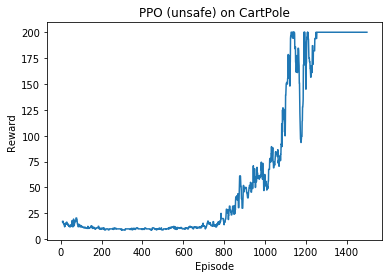

In [180]:
plt.figure()
plt.title('PPO (unsafe) on CartPole')
plt.plot(pd.DataFrame(r).rolling(10).median())
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('ppo.eps', bbox_inches = 'tight')
plt.show()

In [24]:
env = env.unwrapped

In [ ]:
env = gym.wrappers.Monitor(env, './video')
get_rollout()

In [167]:
sess.run(params)

[array([[-0.83253563, -0.68914142, -0.06116719, -0.27323933, -0.5213027 ,
          0.6985349 , -0.64544735,  0.67992079,  0.67211518,  0.17009102],
        [ 0.00793548,  0.66713229,  0.32365717,  0.234717  , -0.25280851,
          0.51593658,  0.35389711, -0.16864096,  0.33962425,  0.00958664],
        [-1.07954104,  0.4448296 ,  0.32367536,  0.01020328,  0.39434612,
          0.26840221,  0.56831521, -0.14168297,  0.32801972,  0.3746401 ],
        [ 0.52174677, -0.66664846, -0.19249984,  0.6350071 , -0.15556228,
          0.54627296,  0.13961452, -0.73726243, -0.16869851, -0.54223824]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[ 0.17059255,  0.11023526,  0.05485238, -0.14846177,  0.63232917,
          0.11522713,  0.04685403, -0.21654478, -0.27550427, -0.05408931],
        [ 0.19957154,  0.05957377, -0.30506767, -0.42670896, -0.16968158,
          0.20515383, -0.00418471,  0.16230165, -0.10987148,  0.37591077],
        [-0.71681118, -0.22760498,  0.04497749,  0.134

In [27]:
tf.train.Saver().save(sess, './cartpole-h1.ckpt')

'./cartpole-h1.ckpt'

In [28]:
tf.train.Saver().restore(sess, './cartpole-h1.ckpt')

INFO:tensorflow:Restoring parameters from ./cartpole-h1.ckpt
